In [1]:
import os,sys,re

# sys.path.insert(0, "/home/wenhao71/.pylib/3")

%load_ext autoreload
%autoreload 2

In [2]:
from typing import *
import wfdb
import scipy
import json
from io import StringIO
from scipy.io import loadmat
from glob import glob
from copy import deepcopy
from random import shuffle
from functools import reduce
from tqdm import tqdm
from scipy.signal import resample, resample_poly
import torch
from itertools import product
from easydict import EasyDict as ED

from data_reader import CPSC2020Reader as CR
from dataset import CPSC2020
from cfg import TrainCfg, ModelCfg, PreprocCfg
from utils import list_sum
from torch_ecg.torch_ecg.models.nets import (
    BCEWithLogitsWithClassWeightLoss,
    default_collate_fn as collate_fn,
)
from torch.utils.data import DataLoader

In [3]:
pwd

'/media/cfs/wenhao71/workspace/cpsc2020'

In [4]:
db_dir = '/media/cfs/wenhao71/data/CPSC2020/TrainingSet/'

In [5]:
dr = CR(db_dir)

In [6]:
dr.all_records

['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10']

In [ ]:
# for rec in dr.all_records:
#     data = dr.load_data(rec, keep_dim=False)
#     print(f"{rec} has max abs value {np.max(np.abs(data))} (max positive values {np.max(data)}, max negative values {np.min(data)})")

In [ ]:
# for rec in dr.all_records:
#     ann = dr.load_ann(rec)
#     spb = ann["SPB_indices"]
#     pvc = ann["PVC_indices"]
#     if len(np.diff(spb)) > 0:
#         print(f"{rec}: min dist among SPB = {np.min(np.diff(spb))}")
#     if len(np.diff(pvc)) > 0:
#         print(f"{rec}: min dist among PVC = {np.min(np.diff(pvc))}")
#     diff = [s-p for s,p in product(spb, pvc)]
#     if len(diff) > 0:
#         print(f"{rec}: min dist between SPB and PVC = {np.min(np.abs(diff))}")

In [ ]:
rec = dr.all_records[1]

In [ ]:
dr.load_ann(rec)

In [ ]:
dr.locate_premature_beats(rec, "pvc")

In [ ]:
# dr.plot(rec,sampfrom=1459472,ticks_granularity=2,sampto=1469472)

In [ ]:
dr.plot(rec,sampfrom=0,ticks_granularity=2,sampto=4000)

In [7]:
ModelCfg

{'fs': 400,
 'n_leads': 1,
 'torch_dtype': 'float',
 'crnn': {'fs': 400,
  'n_leads': 1,
  'torch_dtype': 'float',
  'classes': ['N', 'S', 'V'],
  'class_map': {'N': 0, 'S': 1, 'V': 2},
  'cnn': {'name': 'multi_scopic',
   'multi_scopic': {'groups': 1,
    'scopes': [[[1], [1, 1], [1, 1, 1]],
     [[2], [2, 4], [8, 8, 8]],
     [[4], [4, 8], [16, 32, 64]]],
    'filter_lengths': [[11, 7, 5], [11, 7, 5], [11, 7, 5]],
    'subsample_lengths': [2, 2, 2],
    'num_filters': [[32, 64, 128], [32, 64, 128], [32, 64, 128]],
    'dropouts': [[0, 0.2, 0], [0, 0.2, 0], [0, 0.2, 0]],
    'bias': True,
    'kernel_initializer': 'he_normal',
    'kw_initializer': {},
    'activation': 'relu',
    'kw_activation': {'inplace': True},
    'block': {'subsample_mode': 'max',
     'bias': True,
     'kernel_initializer': 'he_normal',
     'kw_initializer': {},
     'activation': 'relu',
     'kw_activation': {'inplace': True}}}},
  'rnn': {'name': 'linear',
   'linear': {'out_channels': [256, 64],
    'bi

In [8]:
dataset_cfg = ED(TrainCfg.copy())

In [9]:
dataset_cfg.model_name = "seq_lab"
dataset_cfg.classes = ModelCfg[dataset_cfg.model_name].classes
dataset_cfg.class_map = ModelCfg[dataset_cfg.model_name].class_map

In [10]:
PreprocCfg

{'fs': 400,
 'preproc': ['bandpass'],
 'baseline_window1': 80,
 'baseline_window2': 240,
 'filter_band': [0.5, 45],
 'parallel_epoch_len': 600,
 'parallel_epoch_overlap': 10,
 'parallel_keep_tail': True,
 'rpeaks': 'seq_lab',
 'rpeaks_dist2border': 200}

In [11]:
ds = CPSC2020(dataset_cfg, training=True)

In [12]:
len(list_sum([v for v in ds.all_segments.values()]))

157699

In [13]:
for rec, l_seg in ds.all_segments.items():
    print(rec, len(l_seg))

A01 8995
A02 15327
A03 10084
A04 30931
A05 8360
A06 8581
A07 25856
A08 15765
A09 12671
A10 21129


In [ ]:
# with open(ds.segments_json, "w") as f:
#     json.dump(ds.all_segments, f)

In [ ]:
ds._load_seg_seq_lab(ds.segments[0]).shape

In [14]:
ds.__DEBUG__=True

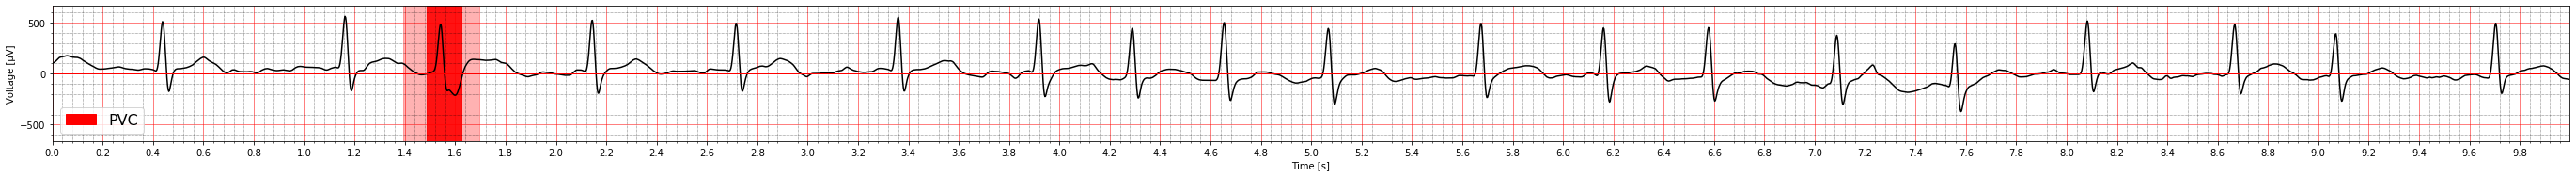

In [16]:
data, label = ds[14000]

In [17]:
np.where(label[:,1]>0.5)[0]*8/400

<IPython.core.display.Javascript object>

array([1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58,
       1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 ])

In [ ]:
# with open("/media/cfs/wenhao71/data/CPSC2020/TrainingSet/segments_backup2/crnn_segments.json", "r") as f:
#     old_segs = json.load(f)
# for rec, l_seg in old_segs.items():
#     print(rec, len(l_seg))

In [ ]:
train_loader = DataLoader(
    dataset=ds,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn,
)

In [ ]:
for signals, labels in train_loader:
    break

In [ ]:
signals.shape

In [ ]:
labels.shape

In [ ]:
pred = torch.rand((32, 500, 2))

In [ ]:
loss = torch.nn.BCEWithLogitsLoss()

In [ ]:
loss(pred, labels)

In [ ]:
ds.disable_data_augmentation()

In [ ]:
ds.__DEBUG__=True

In [ ]:
ds[1]

In [ ]:
ds.segments[10004]

In [ ]:
ds[10004]

In [ ]:
np.std(ds[100095][0]), np.mean(ds[100095][0])

In [ ]:
ds._get_seg_ampl(ds[10003])

In [ ]:
# dr.plot(rec="A02", sampfrom=169*seg_len, sampto=186*seg_len)

In [ ]:
# flat_segs = {rec:[] for rec in dr.all_records}
# valid_segs = {rec:[] for rec in dr.all_records}

# for i, rec in enumerate(ds.reader.all_records):
#     for idx, seg in enumerate(ds.all_segments[rec]):
#         seg_data = ds._load_seg_data(seg)
#         if ds._get_seg_ampl(seg_data) < 0.1:
#             flat_segs[rec].append(seg)
#         else:
#             valid_segs[rec].append(seg)
#         print(f"{idx+1}/{len(ds.all_segments[rec])} @ {i+1}/{len(ds.reader.all_records)}", end="\r")

In [ ]:
# valid_segs

In [ ]:
# len(list_sum([v for v in valid_segs.values()]))

In [ ]:
# len(list_sum([v for v in flat_segs.values()]))

In [ ]:
# len(list_sum([v for v in ds.all_segments.values()]))

In [ ]:
# with open(ds.segments_json, "w") as f:
#     json.dump(valid_segs, f)

In [ ]:
ds.__DEBUG__ = True
ds.disable_data_augmentation()

In [ ]:
all_segs = list_sum([v for k,v in ds.all_segments.items()])

In [ ]:
mean分布, std分布 = [], []

for i, (rec, l_seg) in enumerate(ds.all_segments.items()):
    for idx, seg in enumerate(l_seg):
        data = ds._load_seg_data(seg)
        mean分布.append(np.mean(data))
        std分布.append(np.std(data))
#         print(f"{idx+1}/{len(l_seg)} @ {i+1}/{len(ds.all_segments)}", end="\r", flush=True)

In [ ]:
len(mean分布), len(std分布)

In [ ]:
plt.hist(mean分布)

In [ ]:
np.median(mean分布), np.mean(mean分布)

In [ ]:
plt.hist(std分布)

In [ ]:
np.median(std分布), np.mean(std分布)

In [ ]:
# check = []
# for i, (rec, l_seg) in enumerate(ds.all_segments.items()):
#     for idx, seg in enumerate(l_seg):
#         data = ds._load_seg_data(seg)
#         if np.std(data) < 0.002:
#             check.append(seg)

In [ ]:
std分布_sorted = sorted(std分布)

In [ ]:
std分布_sorted[:10]

In [ ]:
np.sum(np.array(std分布)<0.03)

In [ ]:
check = [all_segs[i] for i in np.where(np.array(std分布)<0.03)[0]]

In [ ]:
no = 0

In [ ]:
print(check[no])
ds.plot_seg(check[no],ticks_granularity=2)
no += 1
print(no)

In [ ]:
ds.plot_seg(ds.all_segments["A09"][2911])

In [ ]:
len(list_sum([v for v in valid_segs.values()]))

In [ ]:
with open(ds.segments_json, "w") as f:
    json.dump(valid_segs, f)

In [ ]:
data = ds._load_seg_data("S08_0001043")
dr.plot("A01", data=data/np.std(data)*0.25, ticks_granularity=2)
ds.plot_seg("S08_0001043")

In [ ]:
ecg_denoise(ds._load_seg_data(ds.segments[0]),400,{"ampl_min":0.15}) == [[0,4000]]

In [ ]:
from scipy.ndimage import median_filter

In [ ]:
data = ds._load_seg_data("S06_0005081")

In [ ]:
from signal_processing.ecg_denoise import ecg_denoise

In [ ]:
# ecg_denoise(data,400,{})
itvs = ecg_denoise(dr.load_data("A02"),400,{"ampl_min":0.15})

In [ ]:
sum([itv[1]-itv[0] for itv in itvs])

In [ ]:
ecg_denoise(ds._load_seg_data())

In [ ]:
no = 370

In [ ]:
ds._load_seg_data(ds.segments[no]).shape

In [ ]:
plt.plot(ds._load_seg_data(ds.segments[no]))

In [ ]:
ds._load_seg_label(ds.segments[no])

In [ ]:
ds._load_seg_beat_ann(ds.segments[no])

In [ ]:
for seg in ds.segments:
    lb = ds._load_seg_label(seg)
    if (lb[1:]>0).any():
        print(seg)

In [ ]:
ds.plot_seg("S01_0001781", ticks_granularity=2)

In [ ]:
# ds._slice_one_record(rec=rec,verbose=2)

In [ ]:
# ds._slice_data(verbose=2)

In [ ]:
# ds._preprocess_one_record("A01",config=PreprocCfg)

In [ ]:
ds.all_segments

In [ ]:
pd = loadmat(os.path.join(ds.preprocess_dir,"A01-bandpass.mat"))

In [ ]:
pd_rpeaks = loadmat(os.path.join(ds.rpeaks_dir, "A01-bandpass.mat"))

In [ ]:
pd['ecg'].squeeze()

In [ ]:
pd_rpeaks['rpeaks'].squeeze()

In [ ]:
rpeaks = pd_rpeaks['rpeaks'].squeeze()[np.where(pd_rpeaks['rpeaks'].squeeze()<400*60*3)]

In [ ]:
# dr.plot("A01", data=pd['ecg'].squeeze()[:400*60*3], rpeak_inds=rpeaks,ticks_granularity=2)
dr.plot("A01", rpeak_inds=rpeaks,ticks_granularity=2)

In [ ]:
dr.load_ann("A01")

In [ ]:
ds._slice_one_record("A01", verbose=2)

In [ ]:
from signal_processing.ecg_rpeaks_dl import seq_lab_net_detect

In [ ]:
data = dr.load_data(rec,keep_dim=False)

In [ ]:
data.shape

In [ ]:
rpeaks = seq_lab_net_detect(data[:30*60*400], 400, verbose=2)

In [ ]:
rpeaks

In [ ]:
dr.plot(rec, data[:3*60*400], rpeak_inds=rpeaks, ticks_granularity=2)

In [ ]:
np.ones((20,20))[0,:5]

In [ ]:
data = dr.load_data(rec, sampfrom=0, sampto=4000, keep_dim=False)
data.shape

In [ ]:
diff = np.max(data) - np.min(data)

In [ ]:
bw = gen_baseline_wander(4000,400,[0.33, 0.1, 0.05, 0.01], diff*np.array([0.02, 0.04, 0.07, 0.1]), 0, diff*0.01)
bw.shape

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))
ax.plot(bw)
ax.plot(data)
ax.plot(data+bw)

In [ ]:
hehe = np.ones((20,4))

In [ ]:
hehe[np.array([2,3,4,5]),...]

In [ ]:
data.shape

In [ ]:
data_rsmp = scipy.signal.resample_poly(data, up=51, down=50)

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))
ax.plot(data_rsmp)
ax.plot(data)

In [ ]:
?scipy.signal.resample

In [ ]:
?np.append

In [ ]:
hehe = np.ones((20,20))

In [ ]:
for _ in range(10):
    hehe = np.append(hehe, np.zeros((1,20)), axis=0)

In [ ]:
?hehe.reshape

In [ ]:
np.ones((10,)).reshape((1,-1)).shape